# This notebook test several score matching methods

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from jax.scipy.stats.multivariate_normal import pdf as jax_normal_pdf
from functools import partial
import optax

import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("")))
from sampling_utlis import ula
from score_matching_utlis import score_matching_loss
from model.model import Score_MLP

### Build target distribution and sample from it

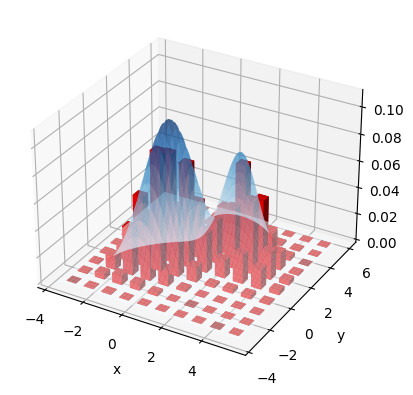

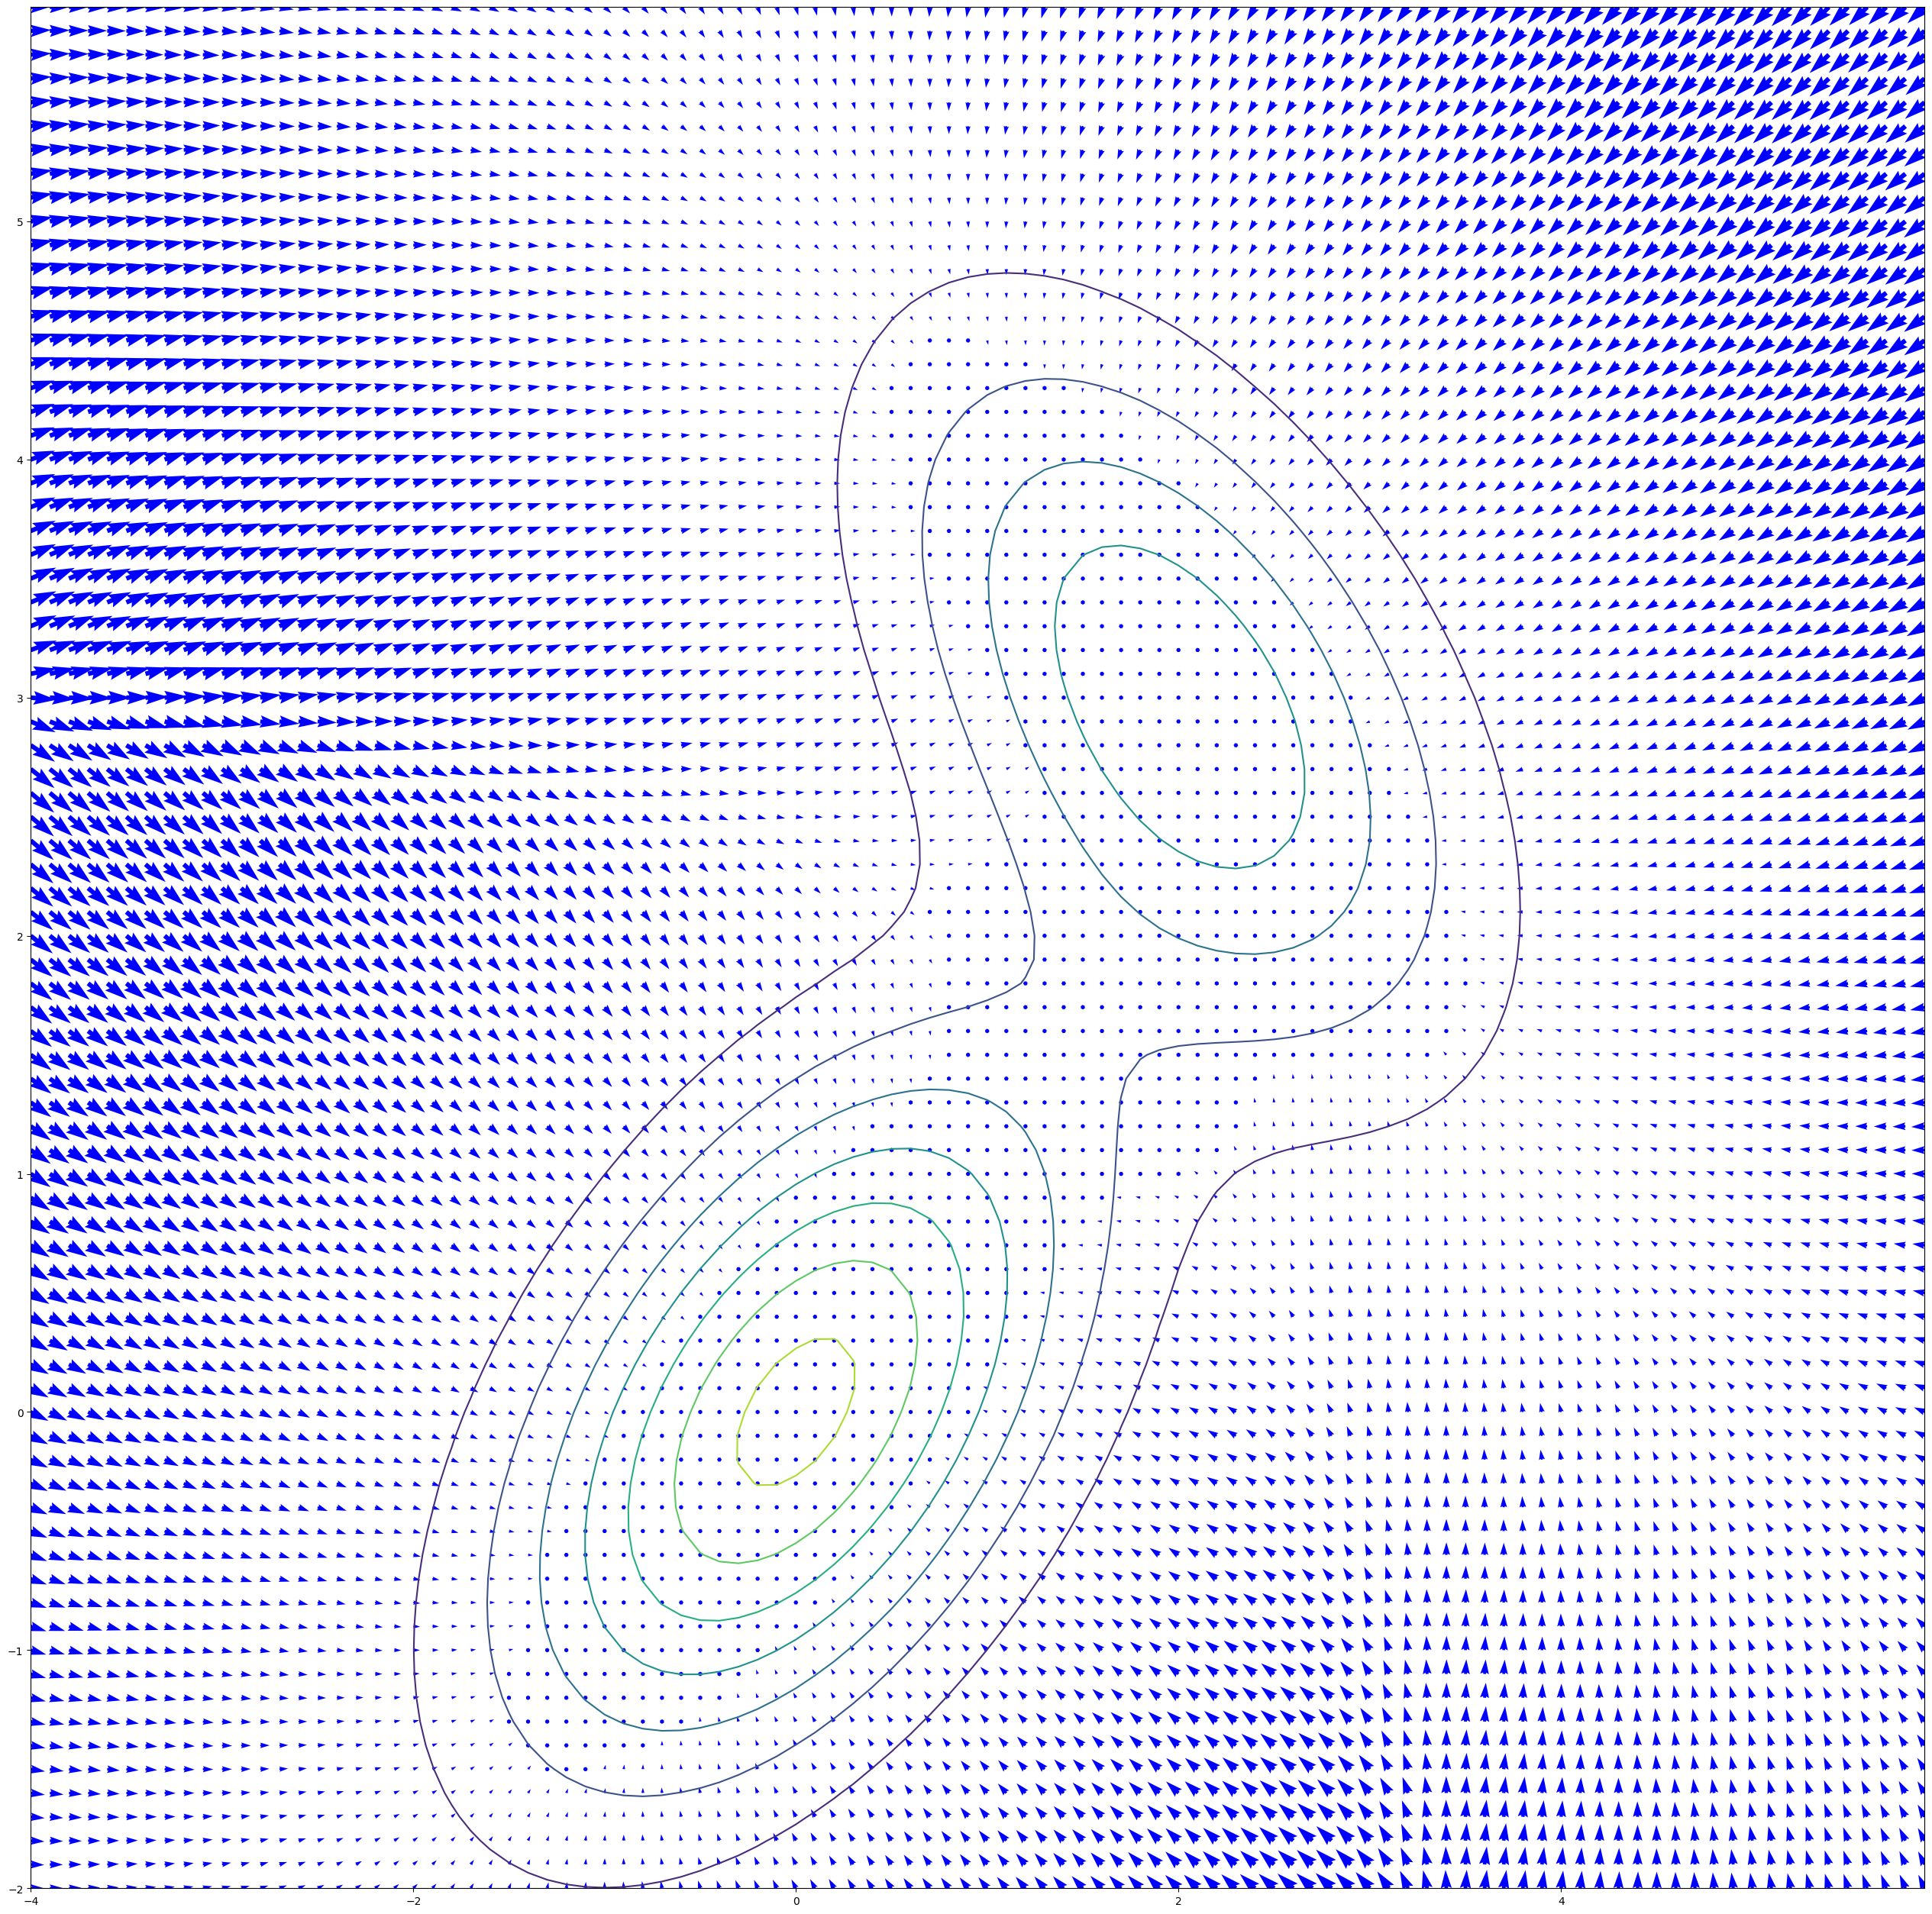

In [2]:
# Define parameters for the mixture of 2D Gaussians
means = np.array([[0, 0], [2, 3]])  # Means of the Gaussians
covs = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])  # Covariance matrices of the Gaussians
weights = [0.6, 0.4]  # Weights of the Gaussians (sums to 1)

# Define target distribution
@jax.jit
def target_pdf(x):
    return jnp.sum(jnp.array([jax_normal_pdf(x, mean=mean, cov=cov) * weight for (mean, cov, weight) in zip(means, covs, weights)]))

def log_target_pdf(x):
    return jnp.log(target_pdf(x))

target_score = jax.jit(jax.jacobian(log_target_pdf))

# Generate samples from the mixture of 2D Gaussians
def generate_samples_2d(n_samples):
    component_choices = np.random.choice(len(means), size=n_samples, p=weights)
    samples = np.zeros((n_samples, 2))
    for i in range(len(means)):
        mask = (component_choices == i)
        samples[mask] = multivariate_normal.rvs(mean=means[i], cov=covs[i], size=np.sum(mask))
    return samples

# Example: Generate 1000 samples from the mixture of 2D Gaussians
samples = generate_samples_2d(10000)

# Plot histogram
def plot_histogram(x, y, density_func=target_pdf):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, density=True)

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)

    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color="red")

    # Compute the density surface
    X, Y = np.meshgrid(np.arange(xedges[0], xedges[-1], 0.01), np.arange(yedges[0], yedges[-1], 0.01))
    densities = jax.vmap(density_func)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)

    ax.plot_surface(X, Y, densities, cmap=cm.Blues, alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

def plot_score(x, y, score_func=target_score, pdf_func=target_pdf, learned_score_func=None):
    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot()
    X, Y = np.meshgrid(x,y)

    # Construct score plot
    scores = jax.vmap(score_func)(np.stack([X.ravel(), Y.ravel()], axis=1))
    dX = scores[:,0].reshape(X.shape)
    dY = scores[:,1].reshape(Y.shape)
    ax.quiver(X, Y, dX, dY, color='b')

    if learned_score_func:
        learned_scores = jax.vmap(learned_score_func)(np.stack([X.ravel(), Y.ravel()], axis=1))
        dX = learned_scores[:,0].reshape(X.shape)
        dY = learned_scores[:,1].reshape(Y.shape)
        ax.quiver(X, Y, dX, dY, color='r')

    # Construct density plot
    pdfs = jax.vmap(pdf_func)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)
    ax.contour(X, Y, pdfs)

plot_histogram(samples[:,0], samples[:,1])
plot_score(np.arange(-4, 6, 0.1), np.arange(-2, 6, 0.1))
plt.show()

### Generate sample use true score function

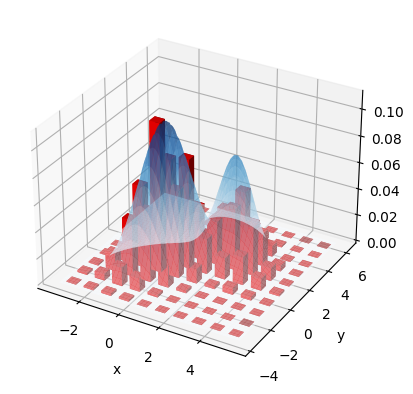

In [3]:
@jax.jit
def score_fn(x, t): 
    return target_score(x)

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=10000)
random_keys = jax.random.split(random_key, 10000)

ula_wrapped = partial(ula, score_fn, T=10, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

plot_histogram(samples[:,0], samples[:,1])
plt.show()

### Use the samples to learn the score function

In [4]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*3, dim=2)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, samples[0], 0)
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(score_matching_loss, model.apply)

In [15]:
# Estimate the lower bound for score matching loss
# The lower bound loss is given by -1/2 E [ \|true_score(X)\|_2^2 ]
expected_loss_lower_bound = -jnp.mean(jnp.sum(jax.vmap(target_score)(generate_samples_2d(10000))**2, axis=1))/2
print("The expecated score matching loss lower bound is:", expected_loss_lower_bound)

The expecated score matching loss lower bound is: -1.0049396


In [5]:
@jax.jit
def params_update(param, optimizer_state, xs):
    ts = jnp.zeros(xs.shape[0])
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for i in range(10000):
    # get a batch of data
    xs = generate_samples_2d(1024)
    # one step grad update
    loss, model_param, optimizer_state = params_update(model_param, optimizer_state, xs)
    losses.append(loss)
    if (i+1) % 1000 == 0:
        print(f"iter:{i+1}, loss:{loss}")

2024-04-13 21:32:50.129100: W external/xla/xla/service/gpu/ir_emitter_triton.cc:761] Shared memory size limit exceeded.


iter:1000, loss:-0.29441213607788086
iter:2000, loss:-0.4410570561885834
iter:3000, loss:-0.5181987285614014
iter:4000, loss:-0.5584284663200378
iter:5000, loss:-0.645234227180481
iter:6000, loss:-0.6325132250785828
iter:7000, loss:-0.6673823595046997
iter:8000, loss:-0.712087869644165
iter:9000, loss:-0.6671038866043091
iter:10000, loss:-0.6903282403945923


In [ ]:
plt.figure()
plt.plot(losses, label="training loss")
plt.plot([expected_loss_lower_bound]*len(losses), label="expected lower bound")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

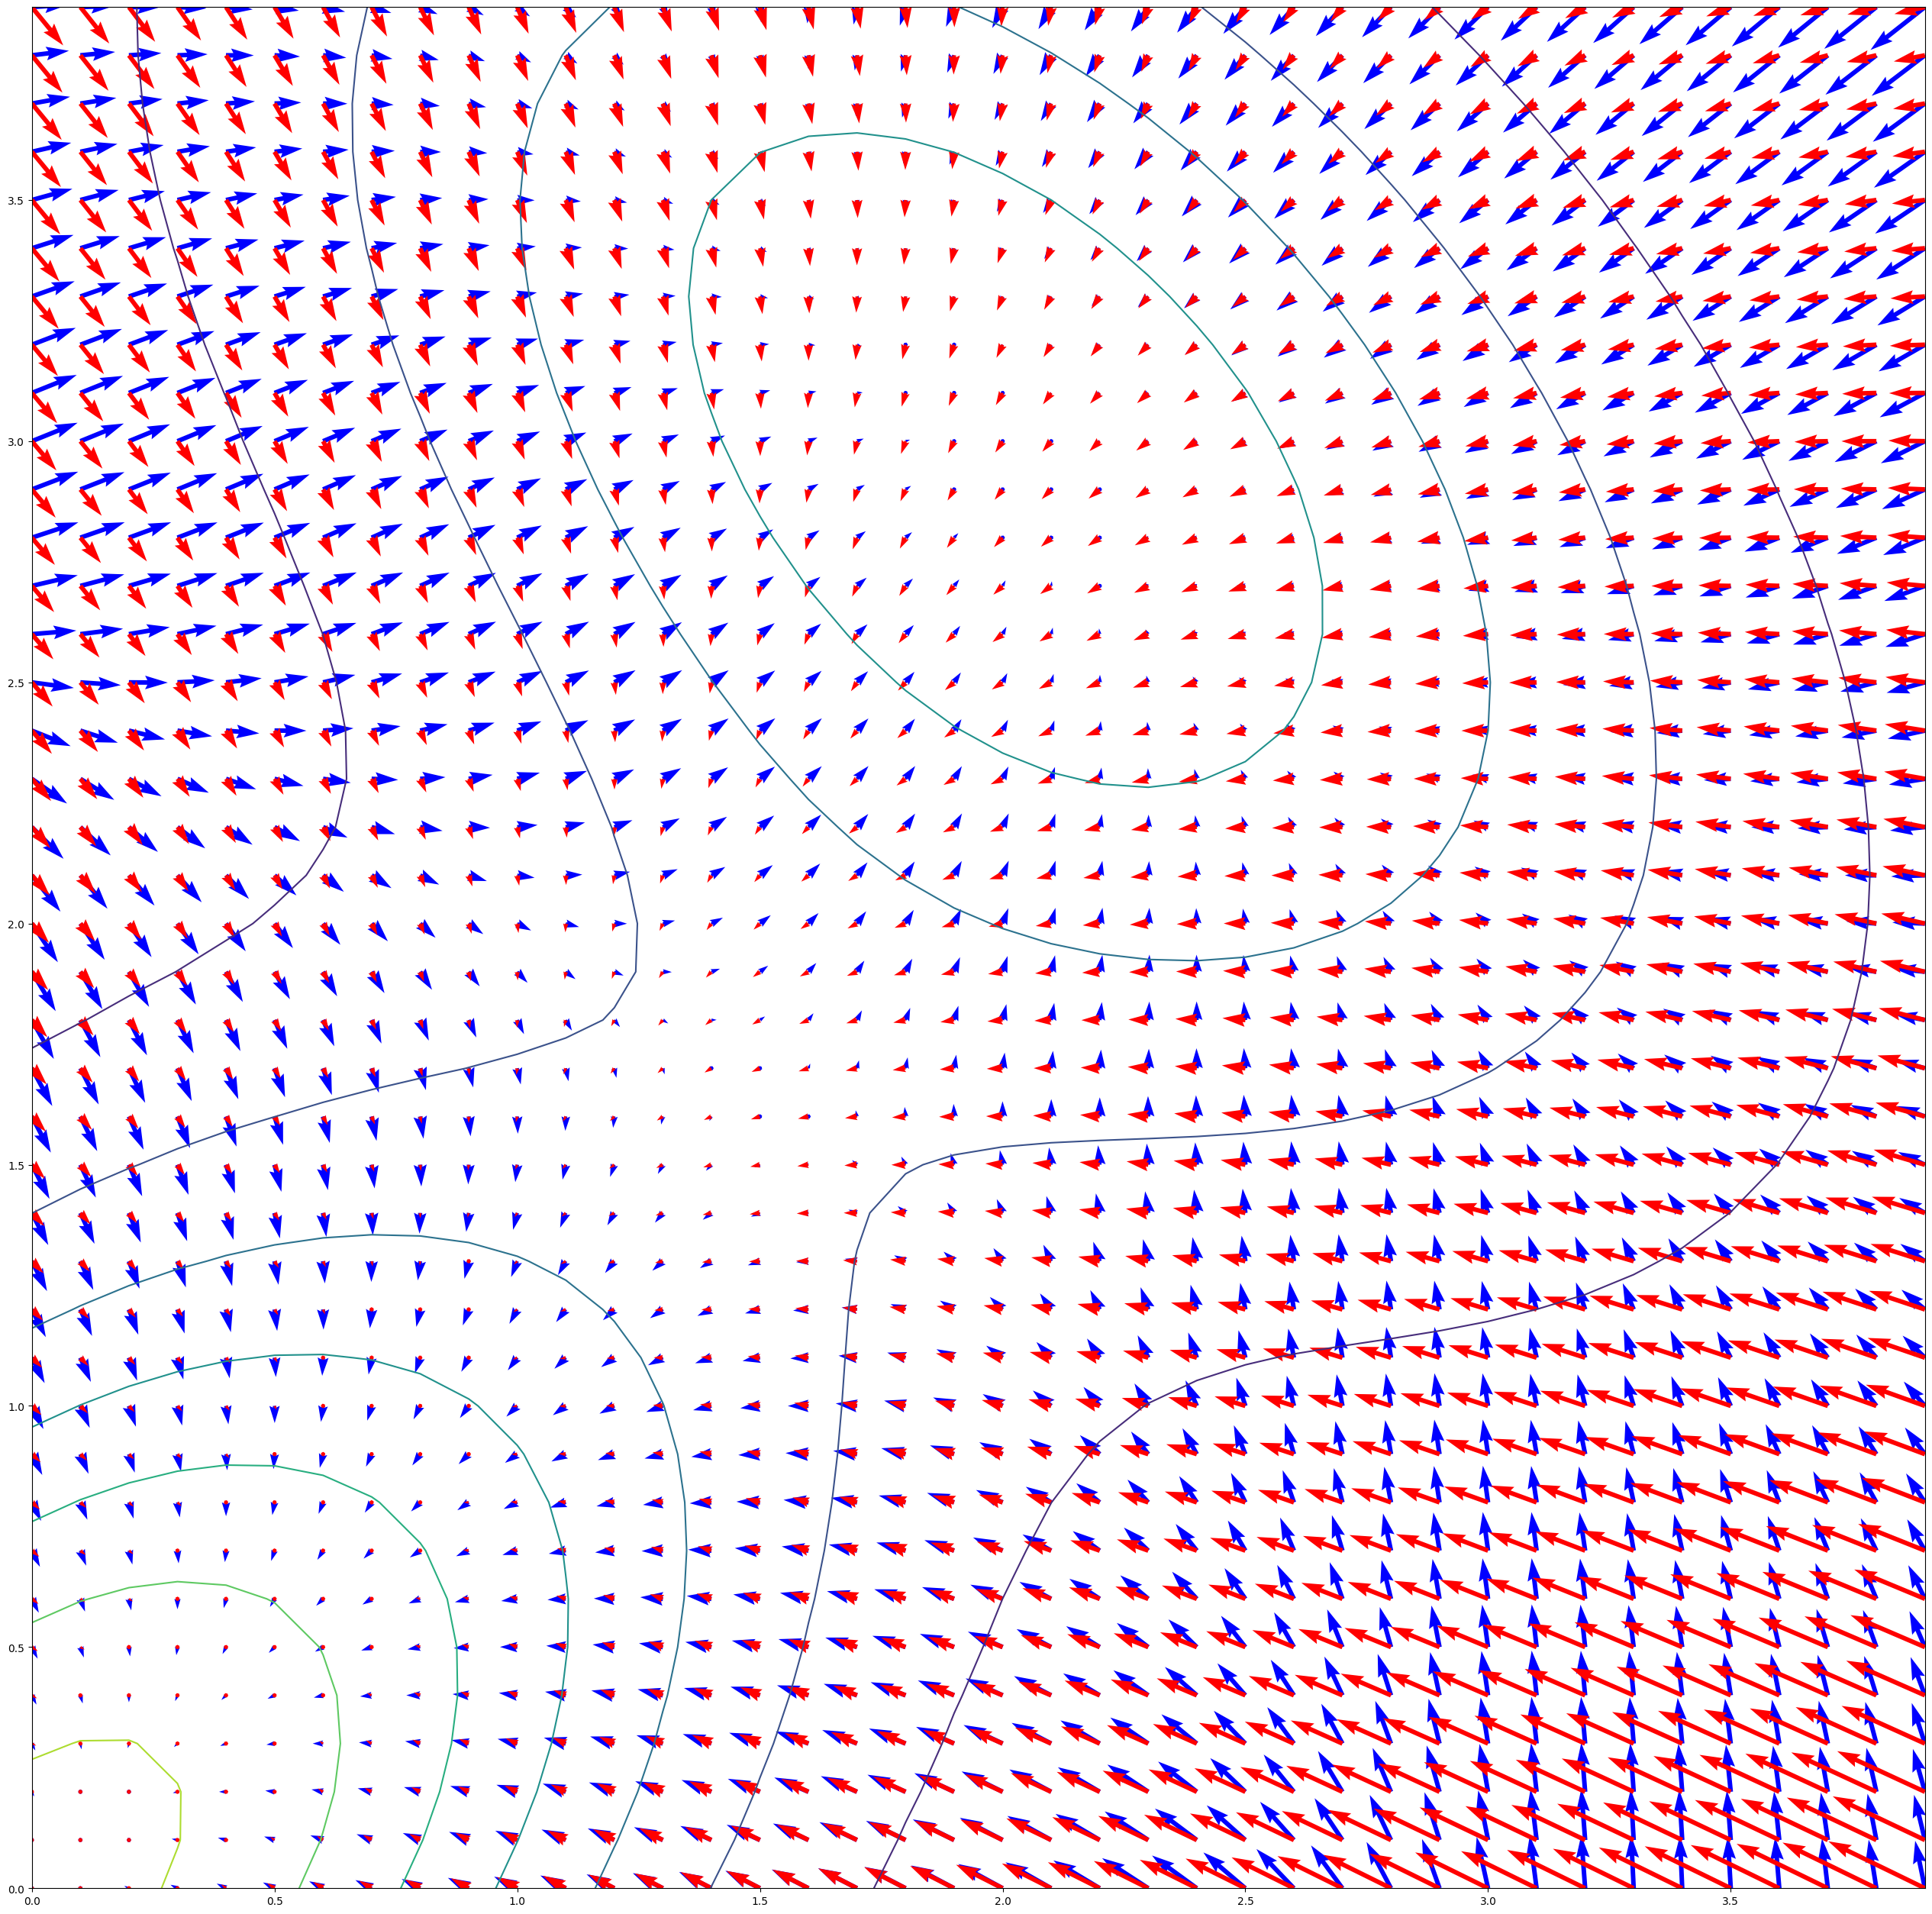

In [6]:
def learned_score_fn(x):
    return model.apply(model_param, x, 0)

plot_score(np.arange(0, 4, 0.1), np.arange(0, 4, 0.1), learned_score_func=learned_score_fn)

### Generate sample use learned score function

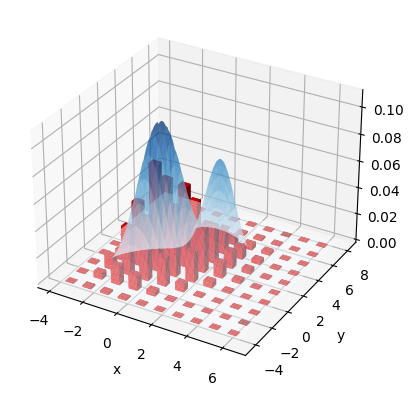

In [10]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t)

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=10000)
random_keys = jax.random.split(random_key, 10000)

ula_wrapped = partial(ula, learned_score_fn, T=10, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

plot_histogram(samples[:,0], samples[:,1])
plt.show()